<a href="https://colab.research.google.com/github/Etinuz/Courses-DL1/blob/master/Lesson_3_SMS_Spam_Classifier_(NLP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Lesson 3 - SMS Spam (NLP)



This notebook is based on the lesson 3 IMDB notebook of the FAST.AI course v3 part 1.

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam. 

https://www.kaggle.com/uciml/sms-spam-collection-dataset



In [0]:
#RUNTIME IN GPU?



In [0]:
#download the latest fast ai library
#!pip3 install fastai==1.0.45

In [1]:

from fastai.text import *
import fastai
fastai.__version__

'1.0.46'

In [0]:
np.random.seed(42)

## Preparing the data

In [3]:
#download the dataset
!wget https://www.dropbox.com/s/abykxcskvpfrcv8/spam.zip?dl=0

--2019-03-03 13:04:39--  https://www.dropbox.com/s/abykxcskvpfrcv8/spam.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.1, 2620:100:6032:1::a27d:5201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/abykxcskvpfrcv8/spam.zip [following]
--2019-03-03 13:04:44--  https://www.dropbox.com/s/raw/abykxcskvpfrcv8/spam.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8ca813f849ed070b9aa834f4fd.dl.dropboxusercontent.com/cd/0/inline/AcZXHTLICvRRGuTYKytYS1hov41HozAsEnpMQYBJr6XI5KPzrIn80KwTU5mfCS5pcKdw1qRxXotbmSkO1RdxVyaizeVyf585ERXRDw-dEmDE29-OEXWqwssBhk2hF9Oy0EI/file# [following]
--2019-03-03 13:04:45--  https://uc8ca813f849ed070b9aa834f4fd.dl.dropboxusercontent.com/cd/0/inline/AcZXHTLICvRRGuTYKytYS1hov41HozAsEnpMQYBJr6XI5KPzrIn80KwTU5mfCS5pcKdw1qRxXotbmSkO1RdxVyaizeVyf585ERXRDw-dEmDE29-OEXWqws

In [4]:
!unzip spam.zip?dl=0

Archive:  spam.zip?dl=0
  inflating: test.csv                
  inflating: train.csv               


In [5]:
path = Path("./")
path.ls()

#There is a train.csv and a test.csv

[PosixPath('.config'),
 PosixPath('train.csv'),
 PosixPath('spam.zip?dl=0'),
 PosixPath('test.csv'),
 PosixPath('sample_data')]

In [6]:
train_df = pd.read_csv('train.csv',encoding='latin-1' ) #encoding because it is an old file
train_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [0]:
test_df = pd.read_csv('test.csv',encoding='latin-1' )


In [8]:
#cleaning the dataset removing some columns and renaming them

for df in [test_df, train_df]:
    df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
    df.rename(columns={'v1': 'label', 'v2':'text'}, inplace=True)
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
label    25 non-null object
text     25 non-null object
dtypes: object(2)
memory usage: 480.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5547 entries, 0 to 5546
Data columns (total 2 columns):
label    5547 non-null object
text     5547 non-null object
dtypes: object(2)
memory usage: 86.8+ KB


In [9]:
train_df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
train_df.shape

(5547, 2)

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs=32 #decrease this size if you run out of GPU memory

Now let's grab the full dataset for what follows.

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [0]:
??NumericalizeProcessor #take a look at the default settings

In [0]:
#here you can make some adjustments to the default settings
txt_proc = [
    TokenizeProcessor(tokenizer=Tokenizer(lang='en'), mark_fields=True),
    NumericalizeProcessor(min_freq=1, max_vocab=60000) 
]

In [0]:
data_lm = (TextList.from_df(train_df, cols='text', processor=txt_proc)
              .random_split_by_pct(0.1)
           #We randomly split and keep 10% for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [15]:
data_lm.show_batch()

idx,text
0,"fa to 87121 to receive entry question(std txt rate)t&c 's apply 08452810075over18 's xxbos xxfld 1 u dun say so early hor ... u c already then say ... xxbos xxfld 1 xxmaj nah i do n't think he goes to usf , he lives around here though xxbos xxfld 1 freemsg xxmaj hey there darling it 's been 3 week 's now and no word back ! i 'd"
1,you . i 'm excited each day i spend with you . xxmaj you make me so happy . xxbos xxfld 1 xxup -pls xxup stop bootydelious ( 32 / f ) is inviting you to be her friend . xxmaj reply xxup yes-434 or xxup no-434 xxmaj see her : www . sms.ac / u / bootydelious xxup stop ? xxmaj send xxup stop xxup frnd to 62468 xxbos
2,"fancy a shag ? i do . xxmaj interested ? sextextuk.com txt xxup xxuk xxup suzy to 69876 . xxmaj txts cost 1.50 per msg . tncs on website . x xxbos xxfld 1 xxmaj just checking in on you . xxmaj really do miss seeing xxmaj jeremiah . xxmaj do have a great month xxbos xxfld 1 xxmaj nah ca n't help you there , i 've never had"
3,"xxmaj no . was awarded a å£2,000 xxmaj bonus xxmaj caller xxmaj prize on 02 / 09 / 03 ! xxmaj this is our 2nd attempt to contact xxup you ! xxmaj call 0871 - 872 - 9755 xxup box95qu xxbos xxfld 1 xxmaj hi i wo n't b ard 4 christmas . xxmaj but do enjoy n merry x'mas . xxbos xxfld 1 xxmaj today 's xxmaj offer !"
4,alerts reply with the word xxup out xxbos xxfld 1 4mths half price xxmaj orange line rental & latest camera phones 4 xxup free . xxmaj had your phone 11mths+ ? xxmaj call mobilesdirect free on 08000938767 to update now ! or2stoptxt t&cs xxbos xxfld 1 xxmaj height of xxmaj confidence : xxmaj all the xxmaj aeronautics professors wer calld & & they wer askd 2 sit in an aeroplane


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [16]:
data_lm.train_ds.x[1] #text

In [17]:
data_lm.train_ds.x.items[1] #numericalized

array([   2,    3,    8,    4,   70,  374,   18,    4, 1356,  457,   19, 1772,   18])

In [18]:
data_lm.vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxfld': 3,
             'xxmaj': 4,
             'xxup': 5,
             'xxrep': 6,
             'xxwrep': 7,
             '1': 8,
             '.': 9,
             'i': 10,
             'to': 11,
             'you': 12,
             ',': 13,
             '?': 14,
             'a': 15,
             'the': 16,
             '!': 17,
             '...': 18,
             'u': 19,
             'and': 20,
             'is': 21,
             'in': 22,
             'me': 23,
             'my': 24,
             'for': 25,
             'it': 26,
             '..': 27,
             'your': 28,
             'do': 29,
             'have': 30,
             'that': 31,
             'of': 32,
             'call': 33,
             'on': 34,
             'are': 35,
             "'s": 36,
             '2': 37,
             'now': 38,
             'so': 39,
             'but': 40,
             'not':

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


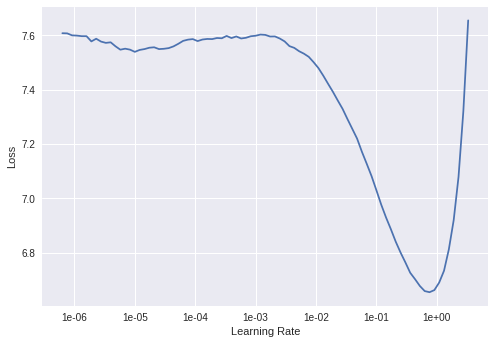

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,5.193193,4.249756,0.295727,00:14


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
TEXT = "I will be "
N_WORDS = 20
N_SENTENCES = 2

In [26]:
#our own sms generator
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I will be  in a few minutes side : If u do nt saw the luck after need to come tomorrow ,
I will be  when you fucking want to make you get to find out out of the part of my wife . i


We not only have to save the model, but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc') 

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [0]:
#we can use the same dataframe train_df

data_clas = (TextList.from_df(train_df, cols='text', vocab=data_lm.vocab)
             .random_split_by_pct(0.2)
             #split by 20% validation and 80% training
             .label_from_df(cols=0)
             #label is in the first column
             .databunch(bs=bs))

data_clas.save('tmp_clas')

In [29]:
data_clas.show_batch(20)

text,target
"xxbos xxmaj the last thing i ever wanted to do was hurt you . xxmaj and i did n't think it would have . xxmaj you 'd laugh , be embarassed , delete the tag and keep going . xxmaj but as far as i knew , it was n't even up . xxmaj the fact that you even felt like i would do it to hurt you shows you",ham
"xxbos xxmaj indians r poor but xxmaj india is not a poor country . xxmaj says one of the swiss bank directors . xxmaj he says that \ < # > lac crore "" of xxmaj indian money is deposited in swiss banks which can be used for ' taxless ' budget for < # > yrs . xxmaj can give < # > crore jobs to all xxmaj indians",ham
"xxbos no , i * did n't * mean to post it . i wrote it , and like so many other times i 've ritten stuff to you , i let it sit there . it xxup was what i was feeling at the time . i was angry . xxmaj before i left , i hit send , then stop . xxmaj it was n't there . i",ham
"xxbos xxmaj solve d xxmaj case : a xxmaj man xxmaj was xxmaj found xxmaj murdered xxmaj on < xxup decimal > . < # > afternoon . 1,his wife called xxmaj police . 2,police questioned everyone . 3,wife : xxmaj sir , i was sleeping , when the murder took place . 4.cook : i was cooking . 5.gardener : i was picking vegetables . 6.house - xxmaj maid",ham
"xxbos xxmaj japanese xxmaj proverb : xxmaj if one xxmaj can do it , u too xxmaj can do it , xxmaj if none xxmaj can do it , u must do it xxmaj indian version : xxmaj if one xxmaj can do it , xxup let xxup him xxup do it .. xxmaj if none xxmaj can do it , xxup leave it ! ! xxmaj and finally xxmaj",ham
"xxbos xxmaj hey babe , sorry i did n't get sooner . xxmaj gary can come and fix it cause he thinks he knows what it is but he does n't go as far a xxmaj ptbo and he says it will cost < # > bucks . i do n't know if it might be cheaper to find someone there ? xxmaj we do n't have any second hand",ham
"xxbos xxmaj can you tell xxmaj shola to please go to college of medicine and visit the academic department , tell the academic secretary what the current situation is and ask if she can transfer there . xxmaj she should ask someone to check xxmaj sagamu for the same thing and lautech . xxmaj its vital she completes her medical education in xxmaj nigeria . xxmaj its less expensive much",ham
xxbos xxmaj for xxmaj the xxmaj first xxmaj time xxmaj in xxmaj the xxmaj history ' xxmaj need ' ' xxmaj comfort ' xxmaj and ' xxmaj luxury ' xxmaj are xxmaj sold xxmaj at xxmaj same xxmaj price xxmaj in xxmaj india .. ! ! xxmaj onion - xxmaj rs . < # > xxmaj petrol - xxmaj rs . < # > xxmaj beer - xxmaj rs .,ham
"xxbos xxmaj plz note : if anyone calling from a mobile xxmaj co. & & asks u to type # < # > or # < # > . xxmaj do not do so . xxmaj disconnect the call , coz it iz an attempt of ' terrorist ' to make use of the sim card no . xxmaj itz confirmd by nokia n motorola n has been verified by",ham
"xxbos xxmaj plz note : if anyone calling from a mobile xxmaj co. & & asks u to type # < # > or # < # > . xxmaj do not do so . xxmaj disconnect the call , coz it iz an attempt of ' terrorist ' to make use of the sim card no . xxmaj itz confirmd by nokia n motorola n has been verified by",ham


In [30]:
# take a look at the numbers. How many data is in your training and validation set
len(data_clas.classes), len(data_clas.train_ds), len(data_clas.valid_ds)

(2, 4438, 1109)

We can then create a model to classify those reviews and load the encoder we saved before.

In [0]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_clas.load_encoder('fine_tuned_enc')#these are the weights of our pre-trained lm model
learn_clas.freeze()

In [32]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


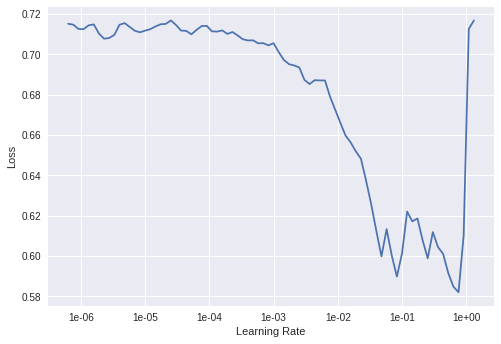

In [33]:
learn_clas.recorder.plot()

In [34]:
learn_clas.fit_one_cycle(3, 3.31E-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.314159,0.123041,0.974752,00:10
2,0.254796,0.091927,0.972047,00:10
3,0.209476,0.089387,0.972047,00:10


In [0]:
learn_clas.save('first')

In [0]:
learn_clas.load('first');

In [0]:
#some SMS-texts to play with
spam1 = 'SMS. ac Sptv: The New Jersey Devils and the Detroit Red Wings play Ice Hockey. Correct or Incorrect? End? Reply END SPTV'

spam2 = "Free entry in 2 a wkly comp to win FA Cup!"

ham1 ='No, I was trying it all weekend'

In [38]:
learn_clas.predict(spam2) #check the prediction of one of above lines

(<fastai.core.Category at 0x7f3e6ce73d30>, tensor(1), tensor([0.0956, 0.9044]))

# Challenge

- improve the classification try to get an accuracy above 0.97 
   (change learning rate, unfreeze, do more epochs, built a better LM)
   
- make predictions on the test dataframe 


In [0]:
#Predict the  text messages which are in the test_df  if they are ham or spam.
result_df = test_df

result = []

for index, row in test_df.iterrows():   
    result.append(learn_clas.predict(row['text'])[0])

In [40]:
#if your model is accurate you should predict 3 spam messages
result_df['prediction'] = result
result_df

,label,text,prediction
0,spam,Had your contract mobile 11 Mnths? Latest Moto...,spam
1,ham,"No, I was trying it all weekend ;V",ham
2,ham,"You know, wot people wear. T shirts, jumpers, ...",ham
3,ham,"Cool, what time you think you can get here?",ham
4,ham,Wen did you get so spiritual and deep. That's ...,ham
5,ham,Have a safe trip to Nigeria. Wish you happines...,ham
6,ham,Hahaha..use your brain dear,ham
7,ham,Well keep in mind I've only got enough gas for...,ham
8,ham,Yeh. Indians was nice. Tho it did kane me off ...,ham
9,ham,Yes i have. So that's why u texted. Pshew...mi...,ham
